# CLASSIFICATION PROBLEM

## NLP multiclass classification problem.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
#reading the data
data = pd.read_csv('data.csv')

In [3]:
#overview the data
data.sample(5)

,34,26989,2020-03-19 21:52:18+00:00,PadSplit,i dont have a key for my room door please give me a call,door
7991,8928.0,39600,2020-09-29 14:19:37+00:00,PadSplit,as soon as my benefits hit my account sometime...,payments
4679,7262.0,40063,2020-10-08 15:03:04+00:00,PadSplit,leslie newsome,no_topic
3985,5284.0,41263,2020-10-28 19:06:17+00:00,PadSplit,the copy of members membership agreement is mi...,no_topic
1455,7983.0,37112,2020-08-19 16:27:02+00:00,PadSplit,hey padsplit support i just tried to apply for...,moving
9045,5324.0,41333,2020-10-30 01:39:32+00:00,PadSplit,hi the padsplit team as you know the above ref...,payments_late


In [4]:
#slicing the data taking only the text and the topic of communication
rent = data.iloc[:, -2: ]
rent.columns = ['text', 'target']

In [5]:
rent.sample(3)

,text,target
4792,i only applied for the ones you all sent me wh...,no_topic
1919,need help with bringing up the map for the dif...,no_topic
5915,hey just wanted to make sure someone was still...,no_topic


In [6]:
#Importing packages for NLP data processing
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/taniaghosh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/taniaghosh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/taniaghosh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


no_topic         4452
payments         2354
payments_late    1592
maintenance       680
roommate          443
moving            437
door              336
main_reply        118
wifi               78
emergency          21
label               1
Name: target, dtype: int64


Text(0.5, 1.0, 'Different topic of emails')

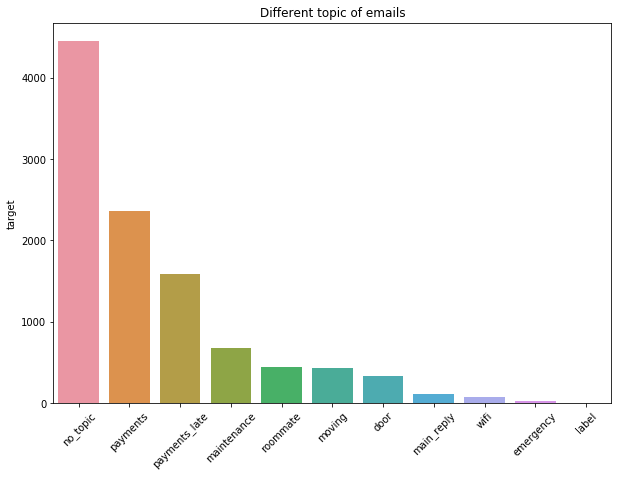

In [7]:
#Plot to sow the different topics of emails
plt.figure(figsize=(10,7))
x=rent['target'].value_counts()
print(x)
sns.barplot(x.index,x)
plt.xticks(rotation =45)
plt.title("Different topic of emails")

In [8]:
#The there is only one instance of 'label' topic which might be a problem for downstream analysis.
#So the row was dropped
rent[rent['target'] == 'label']
rent = rent.drop(357)

## Data Pre-Processing steps for NLP

In [9]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [10]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [11]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
#function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [12]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))


In [13]:
#Running the above pre-processing functions on email text data

rent['clean_text'] = rent['text'].apply(lambda x: finalpreprocess(x))
rent.head()

,text,target,clean_text
0,hello please have someone service or replace o...,door,hello please someone service replace front doo...
1,i called about my house code not working at th...,door,call house code work lilla circle sw address h...
2,hello valorie im so glad you booked a room wit...,door,hello valorie im glad book room padsplit look ...
3,i forgot my code can you please send it to me,door,forgot code please send
4,i would like my lock code to be reactived,door,would like lock code reactived


# Base model

In [14]:
#assigning the x(features) and y(target)
x = rent["clean_text"]
y = rent["target"]


In [60]:
#Splitting the training and test datasets
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,shuffle=True, stratify = y)


In [61]:
#Vectorization
#TF-IDF (term frequency-inverse document frequency) 
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_log_error, mean_squared_error,confusion_matrix,\
        roc_auc_score, f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, precision_recall_curve,\
        fbeta_score, classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier



In [62]:
#Function to check the performance of 4 classifiers

def evaluate_model(X_train, X_test, y_train, y_test):
    classifiers = [LogisticRegression(penalty='l1', solver='liblinear', class_weight = 'balanced'),
                   LinearSVC(class_weight = 'balanced'),RandomForestClassifier(class_weight = 'balanced'),
                   KNeighborsClassifier(n_neighbors=4)
                   ]
    
    for classifier in classifiers:
    
        model = Pipeline(steps = [('classifier', classifier)])
    
        model.fit(X_train, y_train)
        
        predicted_train = model.predict(X_train)
        predicted_test = model.predict(X_test)
    
        print(type(classifier).__name__)
        print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train, predicted_train)))
        print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, predicted_test)))
        print('-' *50)

In [63]:
print(evaluate_model(X_train_vectors_tfidf, X_test_vectors_tfidf, y_train, y_test))

LogisticRegression
Accuracy Score for train data: 0.838
Accuracy Score for test data: 0.808
--------------------------------------------------
LinearSVC
Accuracy Score for train data: 0.958
Accuracy Score for test data: 0.797
--------------------------------------------------
RandomForestClassifier
Accuracy Score for train data: 0.985
Accuracy Score for test data: 0.747
--------------------------------------------------
KNeighborsClassifier
Accuracy Score for train data: 0.523
Accuracy Score for test data: 0.493
--------------------------------------------------
None


The Logistic Regression performance was best among the four. Hence only Logistic model was further tuning

In [64]:
#Logistic Regression(tf-idf), class weight  = balanced as the class distribution is not even.
lr_tfidf=LogisticRegression(solver = 'liblinear', penalty = 'l1', class_weight = 'balanced')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

#Predict y value for train dataset
y_predict_train = lr_tfidf.predict(X_train_vectors_tfidf)
#Predict y value for test dataset
y_predict_test = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train, y_predict_train)))
print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, y_predict_test)))
        

print(classification_report(y_test,y_predict_test))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_test))


Accuracy Score for train data: 0.838
Accuracy Score for test data: 0.808
               precision    recall  f1-score   support

         door       0.71      0.84      0.77       101
    emergency       0.33      0.67      0.44         6
   main_reply       0.47      0.53      0.50        36
  maintenance       0.73      0.84      0.78       204
       moving       0.52      0.76      0.62       131
     no_topic       0.89      0.85      0.87      1336
     payments       0.84      0.74      0.79       706
payments_late       0.85      0.79      0.82       478
     roommate       0.59      0.85      0.70       133
         wifi       0.92      0.96      0.94        23

     accuracy                           0.81      3154
    macro avg       0.69      0.78      0.72      3154
 weighted avg       0.82      0.81      0.81      3154

Confusion Matrix: [[  85    1    2    3    2    3    3    1    1    0]
 [   0    4    0    0    0    2    0    0    0    0]
 [   1    0   19    9    0    

In [65]:
#confusion matrix
conf_mat = confusion_matrix(y_test, y_predict_test)
labels = ['door', 'emergency', 'main_reply', 'maintainence', 'moving', 'no_topic', 'payments', 'payments_late', 'roommate', 'wifi']


Text(62.359375, 0.5, 'True Values')

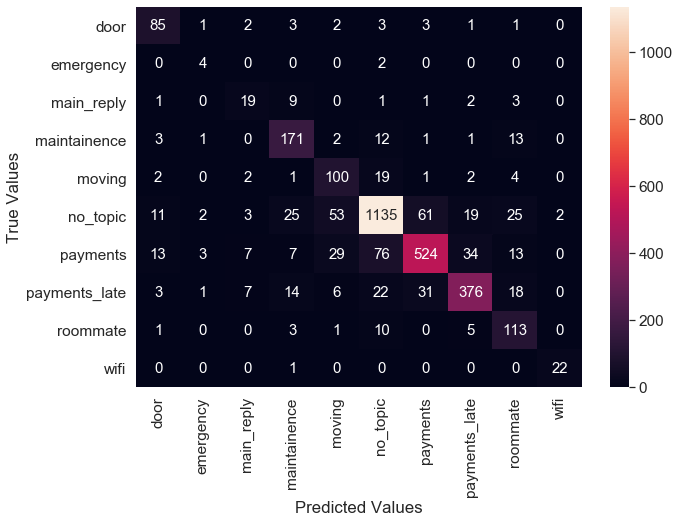

In [66]:
#plotting the confusion matrix
df_cm = pd.DataFrame(conf_mat, range(10), range(10))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='g',annot_kws={"size": 15},xticklabels=labels, yticklabels=labels) # font size
plt.xlabel("Predicted Values") 
plt.ylabel("True Values") 


The Logistic regression model was able to predict the majority class like no_topic, payment and payment_late also the minority class like wifi, emergency. Recall which tells the sensitivity of the model is overall high for all the classes except the main_reply class.

# FEATURE ENGINEERING 

To improve our baseline model, certain features were added by feature engineering

In [23]:
#count the number of characters
def count_chars(text):
    return len(text)

In [24]:
# count the number of words
def count_words(text):
    return len(text.split())

In [25]:
#Number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))


In [26]:
# Number of Unique words
def count_unique_words(text):
    return len(set(text.split()))

In [27]:
#Number of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [28]:
#average word count
rent['word_count'] = rent["text"].apply(lambda x:count_words(x))
rent['char_count'] = rent["text"].apply(lambda x:count_chars(x))
rent['avg_wordlength'] = rent['char_count']/rent['word_count']

In [29]:
#average unique words
rent['sent_count'] = rent["text"].apply(lambda x:count_sent(x))
rent['avg_sentlength'] = rent['word_count']/rent['sent_count']
rent['unique_word_count'] = rent["text"].apply(lambda x:count_unique_words(x))

In [30]:
#how many stopwords vs actual words ratio
rent['unique_vs_words'] = rent['unique_word_count']/rent['word_count']
rent['stopword_count'] = rent["text"].apply(lambda x:count_stopwords(x))
rent['stopwords_vs_words'] = rent['stopword_count']/rent['word_count']

8 new features were added to the original dataset

In [31]:
rent.head(3)

,text,target,clean_text,word_count,char_count,avg_wordlength,sent_count,avg_sentlength,unique_word_count,unique_vs_words,stopword_count,stopwords_vs_words
0,hello please have someone service or replace o...,door,hello please someone service replace front doo...,95,469,4.936842,1,95.0,67,0.705263,53,0.557895
1,i called about my house code not working at th...,door,call house code work lilla circle sw address h...,24,124,5.166667,1,24.0,23,0.958333,10,0.416667
2,hello valorie im so glad you booked a room wit...,door,hello valorie im glad book room padsplit look ...,237,1281,5.405063,1,237.0,132,0.556962,101,0.426160


## Rerunning the data with added engineered features

In [32]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
rent_tfidf1 = tfidf_vectorizer.fit_transform(rent['clean_text']).toarray()

In [33]:
#converting the vectorized data into dataframe
rent_tf_idf = pd.DataFrame(rent_tfidf1)

In [34]:
#merging the vectorized data with the newly added features
rent_final = pd.merge(rent_tf_idf,rent.iloc[:,1:], left_index=True, right_index=True)

In [35]:
#dropping the target and the cleaned text column 
rent_final1 = rent_final.drop(['target', 'clean_text'], axis = 1)

In [36]:
rent_final1.shape

(10510, 13259)

In [37]:
#creatung x and y 
x_re = rent_final1
y_re = rent_final['target']

In [54]:
#train-test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(x_re,y_re,test_size=0.3,shuffle=True, stratify = y_re)

In [55]:
#Running the 4 models again with added features
evaluate_model(X_train_fe, X_test_fe, y_train_fe, y_test_fe)

LogisticRegression
Accuracy Score for train data: 0.846
Accuracy Score for test data: 0.840
--------------------------------------------------
LinearSVC
Accuracy Score for train data: 0.492
Accuracy Score for test data: 0.476
--------------------------------------------------
RandomForestClassifier
Accuracy Score for train data: 0.992
Accuracy Score for test data: 0.772
--------------------------------------------------
KNeighborsClassifier
Accuracy Score for train data: 0.648
Accuracy Score for test data: 0.465
--------------------------------------------------


Logistic regression has better performance among the four classifiers with least train test performace variance. So decided to move ahead with logistic regression

In [67]:
# Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', penalty = 'l1', class_weight = 'balanced', max_iter = 1000)
lr_tfidf.fit(X_train_fe, y_train_fe)

#Predict y value for train dataset
train_predicted = lr_tfidf.predict(X_train_fe)
#Predict y value for test dataset
test_predicted = lr_tfidf.predict(X_test_fe)
y_prob1 = lr_tfidf.predict_proba(X_test_fe)[:,1]

print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train_fe, train_predicted)))
print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test_fe, test_predicted)))
        


print(classification_report(y_test_fe,test_predicted))
print('Confusion Matrix:',confusion_matrix(y_test_fe, test_predicted))

 

Accuracy Score for train data: 0.846
Accuracy Score for test data: 0.840
               precision    recall  f1-score   support

         door       0.72      0.89      0.80       101
    emergency       0.40      0.67      0.50         6
   main_reply       0.50      0.69      0.58        35
  maintenance       0.84      0.80      0.82       204
       moving       0.58      0.78      0.67       131
     no_topic       0.91      0.89      0.90      1336
     payments       0.86      0.78      0.82       706
payments_late       0.88      0.82      0.85       478
     roommate       0.64      0.87      0.74       133
         wifi       0.74      1.00      0.85        23

     accuracy                           0.84      3153
    macro avg       0.71      0.82      0.75      3153
 weighted avg       0.85      0.84      0.84      3153

Confusion Matrix: [[  90    1    0    0    2    2    1    0    4    1]
 [   0    4    0    0    0    1    0    0    1    0]
 [   1    0   24    2    0    

In [68]:
#confusion matrix for training
conf_mat_train = confusion_matrix(y_train_fe, train_predicted)
labels = ['door', 'emergency', 'main_reply', 'maintainence', 'moving', 'no_topic', 'payments', 'payments_late', 'roommate', 'wifi']


Text(62.359375, 0.5, 'True Values')

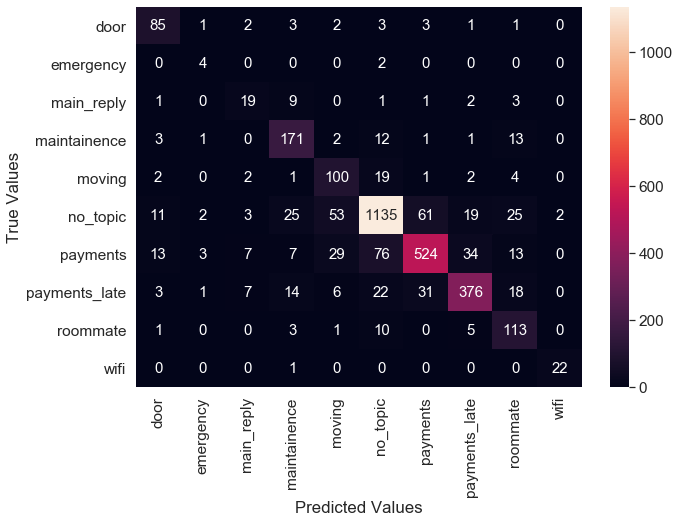

In [70]:
#plotting the confusion matrix for training
df_cm = pd.DataFrame(conf_mat, range(10), range(10))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='g',annot_kws={"size": 15},xticklabels=labels, yticklabels=labels) # font size
plt.xlabel("Predicted Values") 
plt.ylabel("True Values") 


In [71]:
#confusion matrix for test
conf_mat = confusion_matrix(y_test_fe, test_predicted)
labels = ['door', 'emergency', 'main_reply', 'maintainence', 'moving', 'no_topic', 'payments', 'payments_late', 'roommate', 'wifi']


Text(62.359375, 0.5, 'True Values')

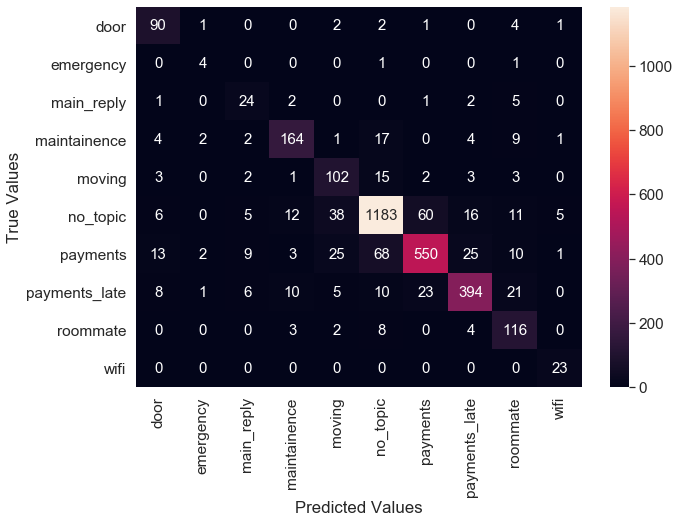

In [72]:
#plotting the confusion matrix for test
df_cm = pd.DataFrame(conf_mat, range(10), range(10))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='g',annot_kws={"size": 15},xticklabels=labels, yticklabels=labels) # font size
plt.xlabel("Predicted Values") 
plt.ylabel("True Values") 


# Summary

- The Logistic regression multiclass classification overall performed better than Random forest, Support vector and k-neighbours classifiers without hyperparameter tuning.
- however other model performance might increase with hypermater-tuning, cross validation or trying different kernal for SVC models
- The train-test especially the test accuracy increased after feature engineering. The train-test variance also get decreased
- Model sensitivity(recall) is higher that is the model is performing better in detecting the false neagative

In [84]:
results = pd.DataFrame({'Model Performanc' : ['original data', 'added features'],
                      'train set' : [83.8, 84.6],
                      'test set' : [80.8, 84.0]})

In [85]:
results

,Model Performanc,train set,test set
0,original data,83.8,80.8
1,added features,84.6,84.0
